## Running and analyzing multiple gpmap-based SLiM simulations

Functions for running multiple `GenotypePhenotypeSLiM` simulations under the same parameters and comparing the overall outputs

In [1]:
import gpmap, gpvolve, os, shutil, subprocess
import pandas as pd, numpy as np
from scipy.sparse import dok_matrix

### 1. Generate a rough mount fuji map with 5 sites that can each have 2 states

In [2]:
gpm = gpmap.simulate.generate_gpm(alphabet='01', num_sites=5, num_states_per_site=2)

# generate fuji fitness landscape towards derived state
gpm.data.loc[:, 'fitness'] = gpmap.simulate.fuji(gpm, ref_genotype = '1'*5, roughness = 0.1)
gpm.data.loc[gpm.data.fitness < 0,"fitness"] = 0.0
gpm.data.loc[max(gpm.data.index),"fitness"] = max(gpm.data.fitness)
gpm.get_neighbors()

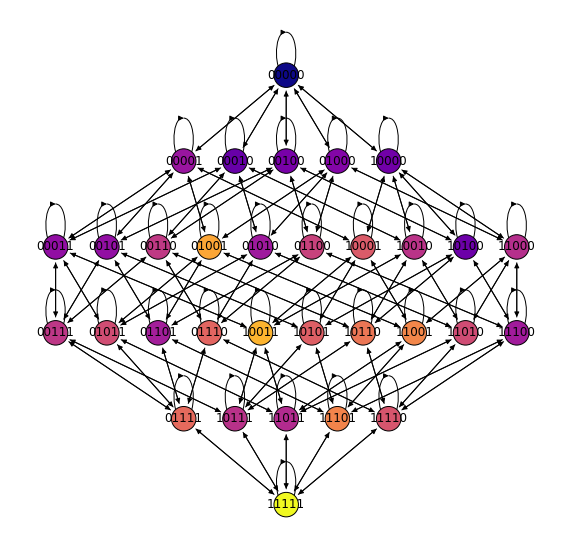

In [3]:
G = gpmap.GenotypePhenotypeGraph()
G.add_gpm(gpm)
G.add_node_cmap(data_column="fitness")
G.add_node_labels(data_column="binary")
G.edge_options["arrows"] = True
G.node_options["node_size"] = 600
_ = gpmap.plot(G,plot_node_labels=True)

### 2. Run with transition path theory

In [4]:
# To calculate T, first get c-friendly representation of neigbors
neighbor_slicer,neighbors = gpvolve.utils.flatten_neighbors(gpm)

# Then calcualte transition matrix given fitness in gpm, neighbors, a fixation model, and a population size
# (fixation_model can be moran, mcclandish, or sswm (strong-selection, weak mutation)). 
T = gpvolve.markov.utils.generate_tmatrix(gpm.fitness,neighbor_slicer,neighbors,
                                          fixation_model="moran",
                                          population_size=10)

print("T is a row-stochastic matrix")
print("T dimensions:",T.shape)
print("column sums:",np.sum(T,axis=0))
print("row sums:",np.sum(T,axis=1))

T is a row-stochastic matrix
T dimensions: (32, 32)
column sums: [0.82343117 0.97383573 0.93160901 0.915508   0.97381139 0.9518108
 1.01965731 1.01609325 0.92683511 1.18703725 0.9579692  1.02132268
 1.07239068 0.87948703 1.06516914 1.02524476 0.9413962  1.0259884
 0.98266704 1.20457755 0.87945913 1.08386135 1.13355768 0.86025322
 1.00885957 1.06974546 1.05204056 0.84149138 0.93574436 1.05905498
 0.96618261 1.213908  ]
row sums: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [5]:
print(T.diagonal())

[0.78868952 0.86853158 0.85359289 0.84329522 0.87658512 0.87072317
 0.90068682 0.9045864  0.84339843 0.96375887 0.8708113  0.90270283
 0.92814121 0.8233095  0.92746153 0.90330158 0.85617082 0.90095799
 0.87709755 0.97110797 0.8222942  0.92956155 0.95102562 0.81051782
 0.89662035 0.92647808 0.92291142 0.79798635 0.85844243 0.91622912
 0.87426214 0.97250152]


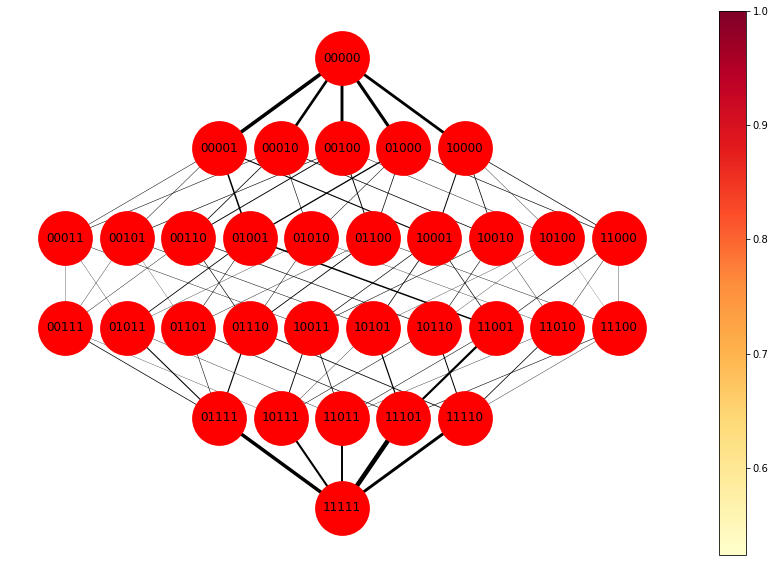

In [6]:
g = gpvolve.markovmodel.GenotypePhenotypeMSM(gpm)
g.transition_matrix = T
flux = gpvolve.flux.TransitionPathTheory(g, [0], [31])
norm_flux = flux.net_flux/flux.total_flux
fig, ax = gpvolve.pyplot.visualization.plot_network(g,
                       flux=dok_matrix(norm_flux), attribute='fitness',
                       colorbar=True, arrows=True)

### 3. Pass gpmap to `run_multiple.py`

`run_multiple.py` is a command-line Python script that runs multiple simulations, saving the edge weights of each unique simulation to a tsv file

In [7]:
N = 100
u = 0.01

# establish multiple-runs directory
if os.path.exists('SLiM_mrs'):
    shutil.rmtree('SLiM_mrs')
os.makedirs('SLiM_mrs')
gpm.to_csv('SLiM_mrs/gpm.txt')

# run_multiple.py
subprocess.run(['python', 'run_multiple.py', 
                '--gpmap','SLiM_mrs/gpm.txt',         # genotype-phenotype map
                '--N',str(N),                         # population size
                '--u',str(u),                         # mutation rate
                '--working_dir','SLiM_mrs/working',   # working directory for SLiM output
                '--slim_out','SLiM_mrs/slim',         # output for SLiM jsons
                '--outpath','SLiM_mrs/out'])          # output for path summary tsv

CompletedProcess(args=['python', 'run_multiple.py', '--gpmap', 'SLiM_mrs/gpm.txt', '--N', '100', '--u', '0.01', '--working_dir', 'SLiM_mrs/working', '--slim_out', 'SLiM_mrs/slim', '--outpath', 'SLiM_mrs/out'], returncode=0)

### 4. Read path summary tsv 

`run_multiple.py` saves the edge weight output of each unique simulation. Average across each edge weight at equilibrium to get an idea of flux...

In [8]:
# read tsv and get edge weights

pathdf = pd.read_csv('SLiM_mrs/out_paths.txt', sep='\t')
slimweights = dict(zip(list(pathdf.columns[2:]), list(pathdf.mean(axis=0, numeric_only=True)[1:]))) # average edge weights over all simulations

gpm.neighbors['slim_weight'] = [0] * len(gpm.neighbors)
for key, value in slimweights.items():
    gpm.neighbors.loc[gpm.neighbors['edge'] ==eval(key), 'slim_weight'] = value

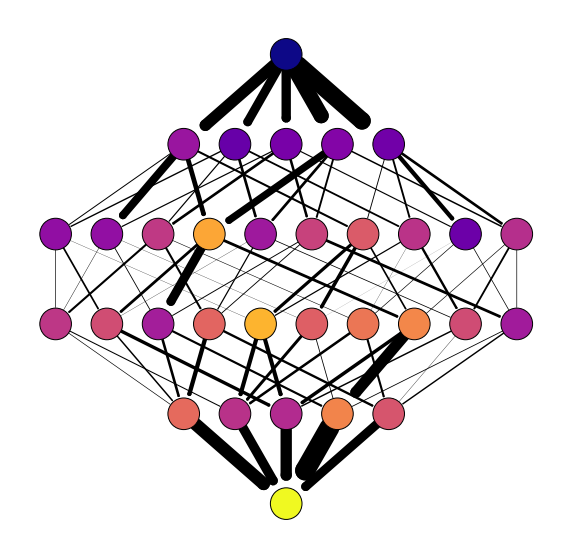

In [9]:
# plot the flux!

G = gpmap.GenotypePhenotypeGraph()
G.add_gpm(gpm)
    
# get rid of self loops
mask = gpm.neighbors.direction != 1
gpm.neighbors.loc[mask, 'include'] = False
    
G.edge_options["arrows"] = None
G.edge_options['arrowsize']=0.001
G.add_edge_sizemap(data_column = 'slim_weight')
G.add_node_cmap(data_column = 'fitness')
g = gpmap.plot(G)

### 5. Compare SLiM and TPT...

Shannon entropy across the whole map:

In [16]:
from scipy.stats import entropy

# sum path probs across TPT edges
scs = list(gpm.neighbors[gpm.neighbors.direction == 1].source)
tgs = list(gpm.neighbors[gpm.neighbors.direction == 1].target)
pprob = []
for i in range(len(scs)):
    s = scs[i]
    t = tgs[i]
    pprob.append(norm_flux[s, t])
TPTent = entropy(pprob)

# edge fluxes for SLiM
SLiMent = entropy(list(pathdf.mean(axis=0, numeric_only=True)[1:]))

print('Shannon entropy across map using TPT:', TPTent)
print('Shannon entropy across map using SLiM:', SLiMent)

Shannon entropy across map using TPT: 4.056842113918524
Shannon entropy across map using SLiM: 4.00754193786495


Difference between probability distributions:

In [17]:
# dictionary of TPT edge fluxes
scs = list(gpm.neighbors[gpm.neighbors.direction == 1].source)
tgs = list(gpm.neighbors[gpm.neighbors.direction == 1].target)
tpt_pprob = {}
for i in range(len(scs)):
    s = scs[i]
    t = tgs[i]
    tpt_pprob.update({(s,t):norm_flux[s, t]})

# dictionary of SLiM edge fluxes
slim_pprob = gpvolve.paths_prob_to_edges_flux(dict(zip([eval(d) for d in pathdf.columns[2:]],list(pathdf.mean(axis=0, numeric_only=True)[1:]))))

# sum differences
diffs = []
for edge in tpt_pprob.keys():
    diff = tpt_pprob[edge] - slim_pprob[edge]
    diffs.append(abs(diff))
    
print("The sum difference between TPT and SLiM probability distributions is", sum(diffs))

The sum difference between TPT and SLiM probability distributions is 0.970406901542847
